# Homework 9 - Descriptive Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the speech from Martin Luther King in the text.text file.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 4th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Wilbert Aristo Guntoro
# Student ID: 1003742

### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()

### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

In [3]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [4]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [5]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [6]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - word2index, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [7]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [8]:
print(vocab)

{'ago', 'shake', 'struggle', 'invigorating', 'despair', 'hampshire', 'vote', 'revealed', 'citizen', 'live', 'shadow', 'oppression', 'note', 'four', 'luxury', 'signs', 'revolt', 'rise', 'highways', 'also', 'redemptive', 'brothers', 'prosperity', 'come', 'rooted', 'until', 'lodging', 'desolate', 'tis', 'men', 'sit', 'white', 'slums', 'georgia', 'let', 'jews', 'stone', 'dream', 'become', 'red', 'as', 'transformed', 'happiness', 'knowing', 'emerges', 'where', 'stating', 'in', 'an', 'see', 'hamlet', 'but', 'cities', 'into', 'hallowed', 'day', 'discrimination', 'those', 'beautiful', 'real', 'that', 'right', 'symbolic', 'five', 'ring', 'chains', 'land', 'table', 'bodies', 'sisters', 'spot', 'oasis', 'old', 'yes', 'rough', 'staggered', 'little', 'americans', 'satisfied', 'selfhood', 'hew', 'there', 'life', 'former', 'plains', 'heat', 'beacon', 'capital', 'promise', 'inalienable', 'rest', 'ghettos', 'happy', 'true', 'police', 'selfevident', 'no', 'fatal', 'sacred', 'sweltering', 'state', 'slave

In [9]:
print(word2index)

{'ago': 0, 'shake': 1, 'struggle': 2, 'invigorating': 3, 'despair': 4, 'hampshire': 5, 'vote': 6, 'revealed': 7, 'citizen': 8, 'live': 9, 'shadow': 10, 'oppression': 11, 'note': 12, 'four': 13, 'luxury': 14, 'signs': 15, 'revolt': 16, 'rise': 17, 'highways': 18, 'also': 19, 'redemptive': 20, 'brothers': 21, 'prosperity': 22, 'come': 23, 'rooted': 24, 'until': 25, 'lodging': 26, 'desolate': 27, 'tis': 28, 'men': 29, 'sit': 30, 'white': 31, 'slums': 32, 'georgia': 33, 'let': 34, 'jews': 35, 'stone': 36, 'dream': 37, 'become': 38, 'red': 39, 'as': 40, 'transformed': 41, 'happiness': 42, 'knowing': 43, 'emerges': 44, 'where': 45, 'stating': 46, 'in': 47, 'an': 48, 'see': 49, 'hamlet': 50, 'but': 51, 'cities': 52, 'into': 53, 'hallowed': 54, 'day': 55, 'discrimination': 56, 'those': 57, 'beautiful': 58, 'real': 59, 'that': 60, 'right': 61, 'symbolic': 62, 'five': 63, 'ring': 64, 'chains': 65, 'land': 66, 'table': 67, 'bodies': 68, 'sisters': 69, 'spot': 70, 'oasis': 71, 'old': 72, 'yes': 73

In [10]:
print(index2word)

{0: 'ago', 1: 'shake', 2: 'struggle', 3: 'invigorating', 4: 'despair', 5: 'hampshire', 6: 'vote', 7: 'revealed', 8: 'citizen', 9: 'live', 10: 'shadow', 11: 'oppression', 12: 'note', 13: 'four', 14: 'luxury', 15: 'signs', 16: 'revolt', 17: 'rise', 18: 'highways', 19: 'also', 20: 'redemptive', 21: 'brothers', 22: 'prosperity', 23: 'come', 24: 'rooted', 25: 'until', 26: 'lodging', 27: 'desolate', 28: 'tis', 29: 'men', 30: 'sit', 31: 'white', 32: 'slums', 33: 'georgia', 34: 'let', 35: 'jews', 36: 'stone', 37: 'dream', 38: 'become', 39: 'red', 40: 'as', 41: 'transformed', 42: 'happiness', 43: 'knowing', 44: 'emerges', 45: 'where', 46: 'stating', 47: 'in', 48: 'an', 49: 'see', 50: 'hamlet', 51: 'but', 52: 'cities', 53: 'into', 54: 'hallowed', 55: 'day', 56: 'discrimination', 57: 'those', 58: 'beautiful', 59: 'real', 60: 'that', 61: 'right', 62: 'symbolic', 63: 'five', 64: 'ring', 65: 'chains', 66: 'land', 67: 'table', 68: 'bodies', 69: 'sisters', 70: 'spot', 71: 'oasis', 72: 'old', 73: 'yes'

In [11]:
print(data)

[('happy', ['i', 'am', 'to', 'join']), ('to', ['am', 'happy', 'join', 'with']), ('join', ['happy', 'to', 'with', 'you']), ('with', ['to', 'join', 'you', 'today']), ('you', ['join', 'with', 'today', 'in']), ('today', ['with', 'you', 'in', 'what']), ('in', ['you', 'today', 'what', 'will']), ('what', ['today', 'in', 'will', 'go']), ('will', ['in', 'what', 'go', 'down']), ('go', ['what', 'will', 'down', 'in']), ('down', ['will', 'go', 'in', 'history']), ('in', ['go', 'down', 'history', 'as']), ('history', ['down', 'in', 'as', 'the']), ('as', ['in', 'history', 'the', 'greatest']), ('the', ['history', 'as', 'greatest', 'demonstration']), ('greatest', ['as', 'the', 'demonstration', 'for']), ('demonstration', ['the', 'greatest', 'for', 'freedom']), ('for', ['greatest', 'demonstration', 'freedom', 'in']), ('freedom', ['demonstration', 'for', 'in', 'the']), ('in', ['for', 'freedom', 'the', 'history']), ('the', ['freedom', 'in', 'history', 'of']), ('history', ['in', 'the', 'of', 'our']), ('of', [

In [12]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.FloatTensor):
    """
    This fucntion converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    tensor =  dtype([word2index[word] for word in words])
    tensor = tensor.cuda()
    
    return Variable(tensor)

### Step 2. Create a SkipGram model and train

Task #1: Write your own model for the SkipGram model below.

In [13]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.total_neighbors = 2 * context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 512)
        self.linear2 = nn.Linear(512, self.total_neighbors * vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        output = F.relu(self.linear1(embeds))
        output = self.linear2(output)
        log_probs = F.log_softmax(output, dim=1).view(self.total_neighbors, -1)
        return log_probs

In [14]:
# Create model and pass to CUDA
context_size = 2
model = SkipGram(context_size = context_size, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.train()

SkipGram(
  (embeddings): Embedding(467, 20)
  (linear1): Linear(in_features=20, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1868, bias=True)
)

In [15]:
# Define training parameters
learning_rate = 0.001
epochs = 300 # <- CUSTOM EPOCH
torch.manual_seed(28)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [16]:
def get_prediction(target, model, word2index):
    """
    This is a helper function to get log probs and prediction indexes from model.
    """
    tensor_target = torch.tensor(word2index[target], dtype=torch.long).cuda()
    log_probs = model(tensor_target)
    context_pred_idxs = log_probs.argmax(dim=1, keepdim=True)
    return log_probs, context_pred_idxs.squeeze().tolist()

Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [17]:
def train(data, word2index, model, epochs, loss_func, optimizer):
    losses = []
    accuracies = []
    for epoch in range(epochs):
        
        # Setup / Reset correct counter and total loss
        correct_count = 0
        total_loss = 0
        
        for target, context in data:
            # Get context indexes
            context_idxs = [word2index[w] for w in context]
            tensor_context_idxs = torch.tensor(context_idxs, dtype=torch.long).cuda()
            
            # Zero out gradients from old instance
            model.zero_grad()
            
            # Get log probabilities and most probable context predictions
            log_probs, context_pred_idxs = get_prediction(target, model, word2index)
            
            # If any of the prediction is correct, add correct counter
            correct_count += len(set(context_idxs).intersection(context_pred_idxs))
            
            # Calculate Loss
            loss = loss_func(log_probs, tensor_context_idxs)
            total_loss += loss.item()
            
            # Backward pass and update gradient
            loss.backward()
            optimizer.step()
        
        # Calculate accuracy & loss for this epoch
        accuracy = round(correct_count / ( len(data) * 2 * context_size ), 3)
        loss = total_loss / len(data)
        print("Epoch {}: Accuracy = {} Loss = {}".format(epoch, accuracy, loss))
        
        # Append accuracy and loss for visualization
        accuracies.append(accuracy)
        losses.append(loss)
            
    return losses, accuracies, model

losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer)

Epoch 0: Accuracy = 0.064 Loss = 7.477917604344595
Epoch 1: Accuracy = 0.116 Loss = 7.292670212945904
Epoch 2: Accuracy = 0.112 Loss = 7.127611689380903
Epoch 3: Accuracy = 0.111 Loss = 6.993345310849227
Epoch 4: Accuracy = 0.112 Loss = 6.887997459601677
Epoch 5: Accuracy = 0.115 Loss = 6.802183051126283
Epoch 6: Accuracy = 0.121 Loss = 6.728959598405505
Epoch 7: Accuracy = 0.131 Loss = 6.664303091327491
Epoch 8: Accuracy = 0.136 Loss = 6.606063589591573
Epoch 9: Accuracy = 0.142 Loss = 6.552941310448155
Epoch 10: Accuracy = 0.15 Loss = 6.503987601134276
Epoch 11: Accuracy = 0.153 Loss = 6.4584621935128315
Epoch 12: Accuracy = 0.158 Loss = 6.41578482716109
Epoch 13: Accuracy = 0.161 Loss = 6.375497330804737
Epoch 14: Accuracy = 0.161 Loss = 6.337260790142724
Epoch 15: Accuracy = 0.165 Loss = 6.300814490810408
Epoch 16: Accuracy = 0.172 Loss = 6.265964886471894
Epoch 17: Accuracy = 0.179 Loss = 6.2325431555615625
Epoch 18: Accuracy = 0.185 Loss = 6.2004063663957805
Epoch 19: Accuracy = 

Epoch 158: Accuracy = 0.386 Loss = 3.8580342190121417
Epoch 159: Accuracy = 0.389 Loss = 3.848727748911576
Epoch 160: Accuracy = 0.39 Loss = 3.8395244734991487
Epoch 161: Accuracy = 0.391 Loss = 3.8304322045044543
Epoch 162: Accuracy = 0.393 Loss = 3.821444954227298
Epoch 163: Accuracy = 0.394 Loss = 3.8125601022693187
Epoch 164: Accuracy = 0.396 Loss = 3.803784867368135
Epoch 165: Accuracy = 0.397 Loss = 3.7951147298371666
Epoch 166: Accuracy = 0.398 Loss = 3.786545855634153
Epoch 167: Accuracy = 0.399 Loss = 3.7780794681603376
Epoch 168: Accuracy = 0.401 Loss = 3.769719419699971
Epoch 169: Accuracy = 0.403 Loss = 3.7614572112670572
Epoch 170: Accuracy = 0.404 Loss = 3.7532992577637643
Epoch 171: Accuracy = 0.406 Loss = 3.7452395541812176
Epoch 172: Accuracy = 0.407 Loss = 3.7372800994173914
Epoch 173: Accuracy = 0.409 Loss = 3.7294198125282643
Epoch 174: Accuracy = 0.41 Loss = 3.721654961117646
Epoch 175: Accuracy = 0.412 Loss = 3.7139889923278973
Epoch 176: Accuracy = 0.413 Loss = 3

### 3. Visualization

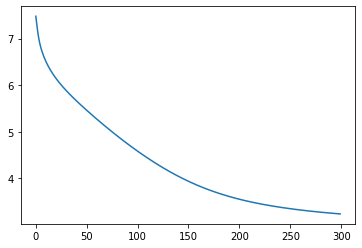

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

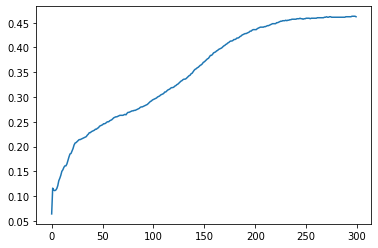

In [19]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

In [24]:
def predict_context_words(model, sample_input):
    _, context_pred_idxs = get_prediction(sample_input, model, word2index)
    context_preds = [index2word[idx] for idx in context_pred_idxs]
    return context_preds

# Initialize another SkipGram model (untrained)
untrained_model = SkipGram(context_size = context_size, embedding_dim = 20, vocab_size = len(vocab))
untrained_model.cuda()

# Get predictions
untrained_predictions = predict_context_words(untrained_model, "demonstration")
trained_predictions = predict_context_words(model, "demonstration")

print("Predicted Context Words from Untrained Model: {}".format(untrained_predictions))
print("Predicted Context Words from Trained Model: {}".format(trained_predictions))

Predicted Context Words from Untrained Model: ['if', 'glory', 'when', 'millions']
Predicted Context Words from Trained Model: ['the', 'greatest', 'for', 'freedom']


### Questions and expected answers for the report

A. Copy and paste your SkipGram class code (Task #1 in the notebook)

B. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration). Please also copy and paste the function call with the parameters you used for the train() function.

C. Why is the SkipGram model much more difficult to train than the CBoW. Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

D. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so. Please submit some code that will demonstrate the performance/problems of the word embedding you have trained!